<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Case-X.-Template" data-toc-modified-id="Case-X.-Template-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Case 3: Patient Drug Review</a></span></li><li><span><a href="#Background" data-toc-modified-id="Background-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Modes-and-training" data-toc-modified-id="Modes-and-training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Modes and training</a></span></li><li><span><a href="#Results-and-Discussion" data-toc-modified-id="Results-and-Discussion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Results and Discussion</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

# Case 3: Patient Drug Review
Team 12: Jari Putaansuu, Samuel Räsänen and Arttu Sundell<br>
Last edited: 18.03.2020<br>
Neural Networks for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

# 2. Background

The main aim is to create a classifier that predicts the the rating (from 1 to 10) of a drug based on the given review. The predictions are simplified by splitting them into three sentimental categories: 

* negative (ratings 1, 2, 3, 4)
* neutral (ratings 5 and 6)
* positive (ratings 7, 8, 9, 10)

## Tools

In [1]:
## Basic tools for data processing and visualizations and 
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # a comprehensive library for data visualization
import os # functions for interacting with the operating system
import tensorflow as tf
from sklearn.model_selection import train_test_split # preprocessing datasets
from tensorflow.keras.utils import to_categorical #create one-hot-encoded output
from sklearn.utils import class_weight #calculate class weights for training using the labels

## Tools for building Recurrent Neural Networks applied in this project
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer #A text tokenizer to vectorize a text corpus
from tensorflow.keras.utils import to_categorical #Converts a class vector (integers) to binary class matrix
from tensorflow.keras.models import Sequential #Sequential model methods
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Embedding, Flatten, Dense, SimpleRNN, Activation, Embedding, LSTM, Bidirectional #The applicable layers used in RNN model
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score # final metrics
from keras.callbacks.callbacks import EarlyStopping # to monitor training and stop when metrics stop improving

## Extra tools needed for review data preprocessing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


Using TensorFlow backend.


# 3. Data

The dataset consists of patient reviews on specific drugs along with related conditions and a 10 star patient rating reflecting overall patient satisfaction. It also contain the number of users who found review useful. The data was obtained by crawling online pharmaceutical review sites.<br>
<br>
The data has six attributes: 
1. drugName (categorical): name of drug
2. condition (categorical): name of condition
3. review (text): patient review
4. rating (numerical): 10 star patient rating
5. date (date): date of review entry
6. usefulCount (numerical): number of users who found review useful<br>

The data is split into a train (75%) a test (25%) partition (see publication) and stored in two .tsv (tab-separated-values) files, respectively. 

The dataset was originally published on the UCI Machine Learning repository
*Felix Gräßer, Surya Kallumadi, Hagen Malberg, and Sebastian Zaunseder. 2018. Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning. In Proceedings of the 2018 International Conference on Digital Health (DH '18). ACM, New York, NY, USA, 121-125*.

In [2]:
#Reading the data into traindata and testdata
traindata = pd.read_csv("../input/kuc-hackathon-winter-2018/drugsComTrain_raw.csv") # 75% trainfraction
testdata = pd.read_csv("../input/kuc-hackathon-winter-2018/drugsComTest_raw.csv") # 25% testfraction

In [3]:
# Examining the data layout

traindata.tail()

,uniqueID,drugName,condition,review,rating,date,usefulCount
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,31-May-15,125
161293,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1,1-Nov-11,34
161294,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2,15-Mar-14,35
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10,19-Sep-15,79
161296,215220,Lubiprostone,"Constipation, Chronic","""I&#039;ve had chronic constipation all my adu...",9,13-Dec-14,116


## Preprocessing the review data

In [4]:
# Preprocessing the used review column data

# Removing unnecessary words and numbers from train data
traindata['review'] = traindata['review'].str.replace(r"[^a-z'A-Z]+", " ") #removing everything else except letters
traindata['review'] = traindata['review'].str.replace('&#039;', "'") #removing HTML from the data
traindata['review'] = traindata['review'].str.replace('&\w+;',' ') #removing special letters

# Removing unnecessary words and numbers from test data
testdata['review'] = testdata['review'].str.replace(r"[^a-z'A-Z]+", " ")
testdata['review'] = testdata['review'].str.replace('&#039;', "'") 
testdata['review'] = testdata['review'].str.replace('&\w+;',' ') 

# Transforming all letters to lowercase for train and test sets
traindata['review'] = traindata['review'].map(lambda x: x.lower())
testdata['review'] = testdata['review'].map(lambda x: x.lower())

# Test print same columns than in the cell above to see if the data is now more usable
traindata.tail()

,uniqueID,drugName,condition,review,rating,date,usefulCount
161292,191035,Campral,Alcohol Dependence,i wrote my first report in mid october of i h...,10,31-May-15,125
161293,127085,Metoclopramide,Nausea/Vomiting,i was given this in iv before surgey i immedi...,1,1-Nov-11,34
161294,187382,Orencia,Rheumatoid Arthritis,limited improvement after months developed ba...,2,15-Mar-14,35
161295,47128,Thyroid desiccated,Underactive Thyroid,i ve been on thyroid medication years i spent...,10,19-Sep-15,79
161296,215220,Lubiprostone,"Constipation, Chronic",i ve had chronic constipation all my adult li...,9,13-Dec-14,116


The data now looks more usable. We decided to use use lemmatization to convert the used verbs into their root form to reduce dimensions of the vocabulary & remove the stopwords before tokenizing the data to improve the quality of the vocabulary.

In [5]:
## Lemmatizing words in reviews to recude the amount of different expressions with identical sentimental value

lemmatizer=WordNetLemmatizer()

# lemmatizing verbs in train and test reviews
traindata['review'] = traindata['review'].map(lambda x: ' '.join(lemmatizer.lemmatize(word, pos="v") for word in word_tokenize(x)))
testdata['review'] = testdata['review'].map(lambda x: ' '.join(lemmatizer.lemmatize(word, pos="v") for word in word_tokenize(x)))

# lemmatizing nouns in train and test reviews
traindata['review'] = traindata['review'].map(lambda x: ' '.join(lemmatizer.lemmatize(word, pos="n") for word in word_tokenize(x)))
testdata['review'] = testdata['review'].map(lambda x: ' '.join(lemmatizer.lemmatize(word, pos="n") for word in word_tokenize(x)))

In [6]:
## Removing unnecessary stopwords from reviews which have no sentimental predictive value

# Selecting the english language stopwords to be used for filtering the text
stopwords = stopwords.words('english')

# Removing english stopwords from both train and test data
traindata['review'] = traindata['review'].map(lambda x: ' '.join(word for word in word_tokenize(x) if word not in stopwords))
testdata['review'] = testdata['review'].map(lambda x: ' '.join(word for word in word_tokenize(x) if word not in stopwords))

In [7]:
# Test print same columns as before to see if the data has a more usable form after processing
traindata.tail()

,uniqueID,drugName,condition,review,rating,date,usefulCount
161292,191035,Campral,Alcohol Dependence,write first report mid october alcohol since p...,10,31-May-15,125
161293,127085,Metoclopramide,Nausea/Vomiting,give iv surgey immediately become anxious coul...,1,1-Nov-11,34
161294,187382,Orencia,Rheumatoid Arthritis,limit improvement month develop bad rash md re...,2,15-Mar-14,35
161295,47128,Thyroid desiccated,Underactive Thyroid,thyroid medication year spend first synthroid ...,10,19-Sep-15,79
161296,215220,Lubiprostone,"Constipation, Chronic",chronic constipation adult life try linz work ...,9,13-Dec-14,116


Looking at the reviews after processing the words and removing unnecessary features have transformed the review into a more usable state for the predictions.


## Splitting the data

In [8]:
## Create three categories for ratings (positive, neutral, negative)

# label = 2, when rating = 7-10 (positive)
# label = 1, when rating = 5-6 (neutral)
# label = 0, when rating = 1-4 (negative)

# Extracting the explanatory variables (x) and response variables (y=rating)

train_x = traindata['review'].values.tolist()
train_y = traindata['rating'].values
for i in range(len(train_y)):
    x = train_y[i]
    if x >= 7:
        train_y[i]=2 #reviews higher than 6 get labes 2, which stands for positive
    elif x > 4:
        train_y[i]=1 #reviews higher than 4 but lower than 7 get labes 1, which stands for neutral
    else:
        train_y[i]=0 #the rest (reviews lower than 5) are labelled 0, and are considered negative

test_x = testdata['review'].values.tolist()
test_y = testdata['rating'].values
for i in range(len(test_y)):
    x = test_y[i]
    if x >= 7:
        test_y[i]=2 
    elif x > 4:
        test_y[i]=1 
    else:
        test_y[i]=0 
    
# Check that the labels are correct by displaying the same tail of traindata as in cells above
train_y[161292:]

array([2, 0, 0, 2, 2])

As it seems the labels match the previously introduced ratings, Saul Goodman - moving on to creating a vocabulary and splitting the train data to train and validation sets.

## Tokenizing input data and one-hot encoding output labels

In [9]:
## Tokenize the traindata review contents

# Initialize Tokenizer
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(train_x)

# Convert reviews to integer sequences (according to the words indexed in the previous step)
train_sequences = tokenizer.texts_to_sequences(train_x)
test_sequences = tokenizer.texts_to_sequences(test_x)

# Test print
print("Train sequences:")
print(train_sequences[0])

# The reviews are padded to have equal length
maxlen = 100
train_sequences = preprocessing.sequence.pad_sequences(train_sequences, maxlen = maxlen)
test_sequences = preprocessing.sequence.pad_sequences(test_sequences, maxlen = maxlen)

# Test print after padding
print("\nTrain sequences after padding:")
print(train_sequences[0])

Train sequences:
[11, 10, 1, 618, 2206, 15, 2494, 1139]

Train sequences after padding:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0   11   10    1  618 2206   15
 2494 1139]


In [10]:
# One hot encoding train and test labels (y-values)

# Test print before one hot encoding
print("Labels before one hot encoding:")
print(train_y[161292:])

train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

# Test print after one hot encoding
print("\nAfter one hot encoding:")
print(train_y[161292:])

Labels before one hot encoding:
[2 0 0 2 2]

After one hot encoding:
[[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


# 4. Models and training

We experimented with different models from simple RNN, also called Vanilla RNN, a long short term memory (LSTM) - model, which is a more comlex model able to remember words further back the in the sentences, and a bidirectional version of LSTM. We were inspired to try out LSTM and bi-LSTM by Pal et al. conference paper, where they applied bi-LSTM to a movie review sentimental analysis, resembling the task at hand. However we decided to make a less deep network (we 2 hidden layer instead of 3 used in the original paper) since more layers ment more burden on the hardware which was more time consuming. Even though there was no huge difference between the models with the small amount of epochs we could try out in the timeframe (RNN/LSTM proved to be very computer costly and time consuming), the bi-LSTM managed to be just a little bit better but we were unable to run enough epochs to make it better than the simpler model.
1. Pal, Subarno; Gosh, Sourmandip; Nag, Amitava 2017. SENTIMENT ANALYSIS IN THE LIGHT OF LSTM RECURRENT NEURAL NETWORKS. Conference paper:International Conference on Information Technology and Applied Mathematics. Researchgate scientific publishing platform 2017. Available online at https://www.researchgate.net/publication/326242364_Sentiment_Analysis_in_the_Light_of_LSTM_Recurrent_Neural_Networks

In [11]:
## Demonstrating our bi-LSTM network that was evaluated alongside the final version

#model = Sequential()
#model.add(Embedding(5000, 16, input_length = maxlen))
#NOTE - first bidirectional layer must have return sequences True to be able to stack with another layer
#model.add(Bidirectional(LSTM(16,dropout=0.2, recurrent_dropout=0.2,return_sequences=True)))
#model.add(Bidirectional(LSTM(16,dropout=0.2, recurrent_dropout=0.2)))
#NOTE - output layer, needs to be the same size as number of classes
#model.add(Dense(3, activation = 'softmax')) 

#model.summary()

In [12]:
## Simple LSTM network that was selected as the final model

# Create a sequential model including Embedding, LSTM and Dense layers
model = Sequential()
#NOTE - embedding layer to turn positive integers (indexes) into dense vectors of fixed size "maxlen" !needs to be the first layer
model.add(Embedding(5000, 16, input_length = maxlen))
model.add(LSTM(16, dropout = 0.2, recurrent_dropout = 0.2))
#NOTE - output layer, needs to be the same size as number of classes
model.add(Dense(3, activation = 'softmax')) 

# model.summary() - disabled for final run as the model can be seen in the code cell here as well.

In [13]:
# Compiling the models and calculating appropriate weights for the classes

#categorical_crossentropy because of problem being multiclass
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc']) 

# Calculating class weights for setting weights during training
# disabled after settling on final model as discussed further

train_y_int = np.argmax(train_y, axis=1) #casting one-hot labels back to integer
class_weights = class_weight.compute_class_weight('balanced', np.unique(train_y_int), train_y_int) #using sklearn.class_weight to calculate balanced weights
dict_class_weights = dict(enumerate(class_weights)) #creating a dictionary for the weights

#print the calculated class weights for each class
print('Weights for each class:')
print(dict_class_weights)

Weights for each class:
{0: 1.3416261176959867, 1: 3.745170428160119, 2: 0.5031129327070037}


In [14]:
# Train the model by fitting the data

# Settings for training
epochs = 10 #this would be set higher when using callbacks to stop the training as setup
patience = 0.1 * epochs
callbackmethod = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.01, verbose=1, patience=patience)

# Training the model with weights
history = model.fit(train_sequences, train_y, 
                    epochs = epochs,
                    batch_size = 32, 
                    validation_split = 0.2)
                    #callbacks=[callbackmethod]) - disabled for final run
                    #class_weight = dict_class_weights - disabled after settling on final model as discussed further
                    

Train on 129037 samples, validate on 32260 samples
Epoch 1/10
129037/129037 [==============================] - 497s 4ms/sample - loss: 0.6625 - acc: 0.7443 - val_loss: 0.6257 - val_acc: 0.7692
Epoch 2/10
129037/129037 [==============================] - 494s 4ms/sample - loss: 0.6039 - acc: 0.7720 - val_loss: 0.6040 - val_acc: 0.7721
Epoch 3/10
129037/129037 [==============================] - 494s 4ms/sample - loss: 0.5632 - acc: 0.7865 - val_loss: 0.5746 - val_acc: 0.7820
Epoch 7/10
129037/129037 [==============================] - 497s 4ms/sample - loss: 0.5529 - acc: 0.7906 - val_loss: 0.5666 - val_acc: 0.7843
Epoch 9/10
129037/129037 [==============================] - 496s 4ms/sample - loss: 0.5483 - acc: 0.7925 - val_loss: 0.5742 - val_acc: 0.7849
Epoch 10/10
 15968/129037 [==>...........................] - ETA: 6:49 - loss: 0.5351 - acc: 0.7991

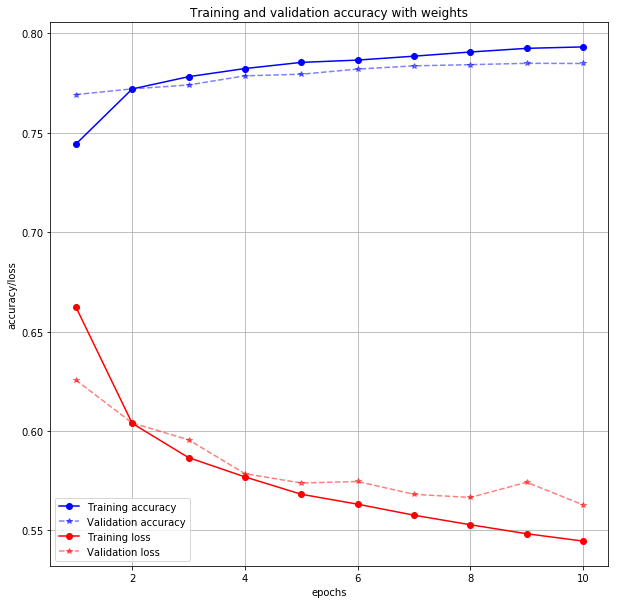

In [15]:
# Checking the the accuracy and loss graphs for the training done

plt.figure(figsize=(10,10))

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, acc, 'bo-', label = "Training accuracy")
plt.plot(epochs, val_acc, 'b*--', alpha=0.5, label = "Validation accuracy")
plt.plot(epochs, loss, 'ro-', label = "Training loss")
plt.plot(epochs, val_loss, 'r*--', alpha=0.5, label = "Validation loss")
plt.title('Training and validation accuracy with weights')
plt.xlabel('epochs')
plt.ylabel('accuracy/loss')
plt.grid()
plt.legend()

plt.show()

# 5. Results & Discussion

## Using class weights for training
With the initial simple LSTM model created we had an issue with labels 1 (rating 5-6) being predicted very seldom compared to the labels 0 and 2, which was caused by the smaller fraction of the data with label 1 in the data set. We tried adding class weights to solve the issue and tested the performance of the models with predicting the unseen test set after 5 and 10 epochs of training.

### Simple LSTM model used for weight testing
> model = Sequential()<br>
> model.add(Embedding(5000, 16, input_length = maxlen))<br>
> model.add(LSTM(16, dropout = 0.2, recurrent_dropout = 0.2))<br>
> model.add(Dense(3, activation = 'softmax')) 

### Weights used calculated with sklearn.utils.class_weight
> label 0: 1.3416261176959867<br>
> label 1: 3.745170428160119<br>
> label 2: 0.5031129327070037

<u> Label 1 predictions using test set after training for 5 epochs</u>
* **without class weights:** only 21 predictions were labeled as 1 (rating 5-6)
* **with class weights**: approximately 6000 predictions were labeled as 1 (rating 5-6)

<u>Label 1 predictions using test set after training for 10 epochs</u>
* **without class weights:** only 71 predictions were labeled as 1 (rating 5-6)
* **with class weights**: approximately 12000 predictions were labeled as 1 (rating 5-6)

### Use of class weights in training after assessing performance
We assessed using class weights with this particular data set in order to assure better predictions for the poorly represented class 1. We ran 2 identical simple LSTM models with identical training data: of which one had class weights enabled for training. The model that used class weights for training clearly started to overemphasize predictions for label 1. After 5 epochs the weighted model seemed better, but after 10 epochs were passed the non-weighted model started to have better metrics on both validation and test sets. The trend seemed to continue running more epochs past 10. Modifying the weights manually so that the class label 1 would have less weight might result in a better outcome.

## Metrics using the unseen test data

### Classification report and confusion matrix reviewed

In [16]:
# Use the model to predict unseen test set and compare the results to known true labels

# assigning predicted values (argmax used to convert one-hot back to int)
predicted = np.argmax(model.predict(test_sequences), axis = 1)
truevalue = np.argmax(test_y, axis = 1)

# creating a classification report
cr = classification_report(truevalue, predicted)

print(cr)

              precision    recall  f1-score   support

           0       0.68      0.71      0.70     13497
           1       0.35      0.03      0.05      4829
           2       0.83      0.92      0.87     35440

    accuracy                           0.79     53766
   macro avg       0.62      0.55      0.54     53766
weighted avg       0.75      0.79      0.75     53766



Assessing the printed classification report it can be clearly seen that the model can sufficiently predict which texts lead to a positive (rating 9-10) review and also does okay with predicting bad reviews. Unfortunately for label 1 (ratings 5-6) the predictions are not so great, due to the small representation in data set.

In [17]:
# Calculating the confusion matrix showing all predictions made for test set

# creating a confusion matrix
cm = confusion_matrix(truevalue, predicted).T
print(cm)

[[ 9563  1765  2669]
 [   87   127   152]
 [ 3847  2937 32619]]


Looking closer at all predictions made we tried to grasp a better understanding on what the model predicted as neutral (rating 5-6) reviews. Seems that it mostly falsely predicted the label 1 for actual positive ratings with true label 2. Also more negative reviews with label 0 were predicted to have the label 1 than actual truely neutral reviews did.

## Cohen's kappa results for the test set

**Cohen's kappa** is relatively a better metric to estimate the accuracy of a multiclass predictions, espescially in this dataset because the label 1 has a poor overall representation compared to other 2 classes - meaning it is easy to obtain a high accuracy even with never predicting anything to be a part of label class 1. Kappa fixes this issue since it measures how much better the classifier predicts compared to random guessing within the target distribution.

<u>Kappa is calculated in the following manner:</u>  *(observed accuracy - expected accuracy)/(1 - expected accuracy)*
> **observed accuracy** = *number of predictions matching the true label divided by the total amount of predictions*<br>
> **expected accuracy** = *for each class calculate marginal frequency (amount of true labels x amount of predicted labels / total amount of labels). Add the marginal frequencies together and divide them using the total amount of predictions. As a result you get the expected accuracy.*

<u>Example:</u>
*30 total labels, true labels: 15 men, 15 women. Predictions represented in a confusion:*
![](https://users.metropolia.fi/~samuer/cr7.jpg)

  
This would mean the **observer accuracy** would be: (10 + 8 / 30) = **0.6**<br>
and the **marginal frequency for women** classifier:  (15 x 17 / 30) = **8.5**<br>
also **marginal frequency for men** clasiffier: (15 x 13 / 30) = **6.5**<br>
So the **total expected accuracy** would be calculated (8.5 + 6.5 / 30) = **0.5**<br>

The **kappa** would then be calculated as follows: (0.6 - 0.5) / (1 - 0.5) = **0.2**, which is not too good. A good value for kappa would be over 0.61, in which case the classifier is actually doing it's job properly with each class. Typically Kappa between 0.41–0.60 is considered moderate, 0.61–0.80 is considered as substantial, and 0.81–1.00 is considered as almost perfect interrater reliability.  

In [18]:
# Calculating the cohen's kappa for test set predictions with linear and quadratic weights (weighted training)

kappa = cohen_kappa_score(truevalue, predicted)
print(f"Cohen's kappa (linear)    = {kappa:.3f}")
quadkappa = cohen_kappa_score(truevalue, predicted, weights = 'quadratic')
print(f"Cohen's kappa (quadratic) = {quadkappa:.3f}")

Cohen's kappa (linear)    = 0.527
Cohen's kappa (quadratic) = 0.620


The cohen's kappa clearly shows that the model is good, but not great.

In [19]:
# Raw loss and accuracy calculated for the test set (weighted model)

model.evaluate(test_sequences, test_y)

53766/53766 [==============================] - 38s 709us/sample - loss: 0.5561 - acc: 0.7869


[0.5561193884809214, 0.78690994]

Accuracy is decent as can be seen from the model evaluation, but cohen's kappa would need some improving with using more epochs for the training phase as the model hasn't yet started overfitting. Optionally the bidirectional LSTM model would also do fine if we had NASA computers to run a third biLSTM layer with tons of epochs.

# 6. Conclusions

It seems that RNN let alone LSTM is very computer costly, and therefore very time consuming. In order to really see difference in performance, the model training should be run with a big amount of epochs and use early stopping to stop the training at optimal stage. With the amount of training for each of the models we couldn't get there. 

Judging by the literature bi-LSTM should perform better. However we could not verify that with the amount of epochs run. LSTM and bi-LSTM proved to be the heaviest on hardware and had pretty much of the same burden computerwise. We noticed, that adding an extra layer to the model, the time consumed per epoch was roughly doubled and even with the TPU activated it is too time consuming to benchmark within our given timeframe for the assignment.

The accuracy gained with the simple LSTM model was decent and we are somewhat happy with the results, at leas in terms of learning what would be needed to go further with the bidirectional LSTM models. Pal et al. managed to get an accuracy of roughly 84 % for a model that was more complex and categorizing the sentiment only as positive or negative. So compared to that the our bidirectional LSTM model was OK. However, the model presented in this notebook would not be of very practical. If we had more calculation power to run faster epochs and to build a more complex bidirectional LSTM model closer to what Pal et al. had, perhaps we could get closer to their achieved metrics.